***Rigid Body Test***

Free fall test, and force measurement of rigid bodies with default simulation properties

In [1]:
from isaacsim import SimulationApp
simulation_app = SimulationApp({"headless": False})

import numpy as np
import matplotlib.pyplot as plt
import csv
import imageio
from datetime import datetime

from isaacsim.core.api import World
from isaacsim.core.api.objects import DynamicCuboid, FixedCuboid
from isaacsim.core.prims import RigidPrim
from pxr import UsdGeom, UsdPhysics

Starting kit application with the following args:  ['/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/exts/isaacsim.simulation_app/isaacsim/simulation_app/simulation_app.py', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/apps/isaacsim.exp.base.python.kit', '--/app/tokens/exe-path=/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit', '--/persistent/app/viewport/displayOptions=3094', '--/rtx/materialDb/syncLoads=True', '--/rtx/hydra/materialSyncLoads=True', '--/omni.kit.plugin/syncUsdLoads=True', '--/app/renderer/resolution/width=1280', '--/app/renderer/resolution/height=720', '--/app/window/width=1440', '--/app/window/height=900', '--/renderer/multiGpu/enabled=True', '--/app/fastShutdown=False', '--/app/installSignalHandlers=0', '--ext-folder', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/exts', '--ext-folder', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/apps', '

2025-12-10T06:29:54Z [89,511ms] [Error] [asyncio] Exception in callback _patch_task.<locals>.step()
handle: <Handle _patch_task.<locals>.step()>
Traceback (most recent call last):
  File "/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit/python/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x732f4b1ff300> is already entered
2025-12-10T06:30:01Z [95,699ms] [Error] [asyncio] Task was destroyed but it is pending!
task: <Task pending name='Task-11201' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit/python/lib/python3.11/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-11202' coro=<Kernel.shell_main() running at /home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit/python/lib/python3.11/site-packages/ipykerne

Plots saved → rigid_test_20251210_152833_plots.png
[96.053s] Simulation App Shutting Down
[96.054s] [ext: isaacsim.exp.base.python-5.1.0] shutdown
[96.054s] [ext: isaacsim.exp.base-5.1.0] shutdown
[96.054s] [ext: omni.isaac.window.about-2.0.7] shutdown
[96.055s] [ext: isaacsim.app.about-2.0.11] shutdown
[96.104s] [ext: omni.isaac.asset_browser-1.0.6] shutdown
[96.105s] [ext: omni.isaac.assets_check-0.3.13] shutdown
[96.105s] [ext: isaacsim.asset.browser-1.3.23] shutdown
[96.176s] [ext: isaacsim.asset.importer.mjcf-2.5.13] shutdown
[96.469s] [ext: isaacsim.asset.importer.urdf-2.4.30] shutdown
[96.761s] [ext: omni.isaac.cortex.sample_behaviors-2.0.5] shutdown
[96.762s] [ext: isaacsim.cortex.behaviors-2.0.14] shutdown
[96.762s] [ext: omni.isaac.menu-1.0.6] shutdown
[96.762s] [ext: isaacsim.gui.menu-2.4.4] shutdown
[97.461s] [ext: omni.replicator.isaac-2.0.8] shutdown
[97.461s] [ext: isaacsim.replicator.domain_randomization-1.0.16] shutdown
[97.462s] [ext: isaacsim.replicator.examples-1.3.

In [2]:
# Simulation parameters
DT = 1/60               # physics timestep
DROP_HEIGHT = 1.2       # initial height of dynamic cube
BLOCK_SIZE = 0.5        # size of lower block
TOP_MASS = 1.0          # kg
SAVE_PREFIX = "rigid_test_" + datetime.now().strftime("%Y%m%d_%H%M%S")
VIDEO_FILE = SAVE_PREFIX + ".mp4"
CSV_FILE = SAVE_PREFIX + ".csv"

time_log = []
height_log = []
force_log = []
frames = []             # store PNG frames for video

In [3]:
def create_world():
    world = World(stage_units_in_meters=1.0)
    stage = world.stage   # correct handling
    world.scene.add_default_ground_plane()
    return world, stage


def create_fixed_block(world):
    return world.scene.add(
        FixedCuboid(
            prim_path="/FixedBlock",
            name="fixed_block",
            position=np.array([0, 0, BLOCK_SIZE / 2]),
            size=BLOCK_SIZE,
            color=np.array([255, 0, 0])
        )
    )

def create_dynamic_block(world):
    return world.scene.add(
        DynamicCuboid(
            prim_path="/TopCube",
            name="top_cube",
            position=np.array([0, 0, DROP_HEIGHT]),
            size=BLOCK_SIZE,
            mass=TOP_MASS,
            color=np.array([255, 255, 0])
        )
    )

def create_contact_view(world):
    view = RigidPrim(
        prim_paths_expr="/TopCube",
        contact_filter_prim_paths_expr=["/FixedBlock"],
        name="contact_view",
        max_contact_count=16,
    )
    world.scene.add(view)
    return view

def save_csv(time_log, height_log, force_log):
    with open(CSV_FILE, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["time_s", "height_m", "normal_force_N"])
        for t, h, fn in zip(time_log, height_log, force_log):
            writer.writerow([t, h, fn])
    print("CSV saved →", CSV_FILE)


In [4]:


world,stage  = create_world()
fixed_block = create_fixed_block(world)
top_block = create_dynamic_block(world)
contact_view = create_contact_view(world)

world.reset()

print("Initial scene ready.")


In [5]:
time = 0.0

while simulation_app.is_running():
    # Only run sim-logic while Play is active
    if world.is_playing():

        # time update (better: derive from sim time if you want)
        time += DT
        time_log.append(time)

        # cube height
        z = top_block.get_world_pose()[0][2]
        height_log.append(z)

        # contact force
        result = contact_view.get_contact_force_data(dt=DT)
        if result is not None:
            forces, points, normals, distances, counts, starts = result
            if forces.shape[0] > 0:
                fn = np.sum(np.sum(forces * normals, axis=1))
            else:
                fn = 0.0
        else:
            fn = 0.0

        force_log.append(fn)

    # You can react to Stop as well (optional)
    if world.is_stopped():
        # e.g., finalize / plot / save here if you want to end on Stop
        # break   # uncomment to exit script when user presses Stop
        pass

    world.step(render=True)


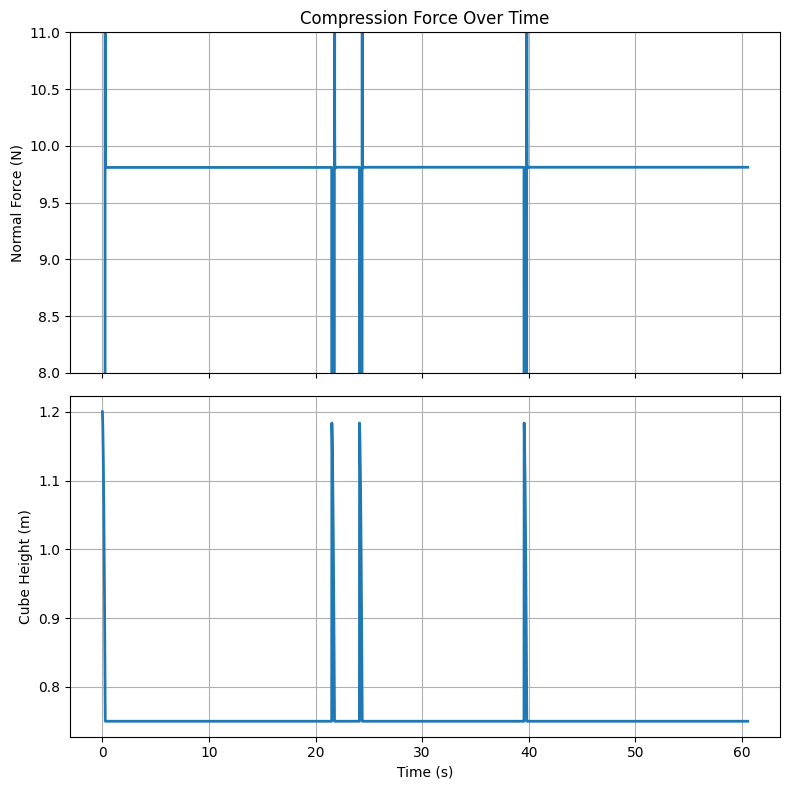

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8,8), sharex=True)

ax[0].plot(time_log, force_log, linewidth=2)
ax[0].set_ylabel("Normal Force (N)")
ax[0].set_ylim(8, 11)
ax[0].set_title("Compression Force Over Time")
ax[0].grid(True)

ax[1].plot(time_log, height_log, linewidth=2)
ax[1].set_ylabel("Cube Height (m)")
ax[1].set_xlabel("Time (s)")
ax[1].grid(True)

plt.tight_layout()
plt.savefig(SAVE_PREFIX + "_plots.png", dpi=300)
plt.show()

print("Plots saved →", SAVE_PREFIX + "_plots.png")

simulation_app.close()

